# Individual Project

## Data Analysis and Visualization of Large Wildfire Spread in Portugal

In [315]:
import pandas as pd
import numpy as np
import re
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

In [262]:
firespread = pd.read_excel("PT-FireSprd_L3_FireBehavior.xlsx")
firespread.head()

,fid,fname,burn_perio,year,sdate,edate,qc,inidoy,enddoy,duration,area,growth_rat,ros,spdir,max_ros,FRE,FRE_perc,FRE_flux
0,29,Abrantes,1,2017,2017-08-09 18:00,2017-08-09 23:00,3,221.750000,221.958333,5.0,500.00,100.000160,1199.623292,155.744885,1199.623292,-1.00000,60.0,-1.000000
1,29,Abrantes,2,2017,2017-08-09 23:00,2017-08-10 03:00,3,221.958333,222.125000,4.0,195.75,48.937402,388.377944,181.152080,393.534571,-1.00000,12.5,-1.000000
2,29,Abrantes,3,2017,na,2017-08-10 12:00,3,-1.000000,222.500000,-1.0,191.75,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,0.0,-1.000000
3,29,Abrantes,4,2017,2017-08-10 12:00,2017-08-10 14:30,3,222.500000,222.604167,2.5,1184.25,473.698484,1088.042456,238.370571,1088.042456,11.37195,100.0,3.841064
4,29,Abrantes,5,2017,2017-08-10 14:30,2017-08-10 22:00,3,222.604167,222.916667,7.5,1552.50,207.000000,580.932693,170.189772,585.006347,40.08456,100.0,3.442582


In [263]:
firespread.columns

Index(['fid', 'fname', 'burn_perio', 'year', 'sdate', 'edate', 'qc', 'inidoy',
       'enddoy', 'duration', 'area', 'growth_rat', 'ros', 'spdir', 'max_ros',
       'FRE', 'FRE_perc', 'FRE_flux'],
      dtype='object')

### Column Details:

- fid: Fire Id
- fname: Fire Name
- burn_perio: Burning Period
- year
- sdate: start date
- edate: end date
- qc: confidence flag
- inidoy: start day-of-year
- enddoy: end day-of-year
- duration (hours)
- area (ha)
- growth_rat: growth rate (ha/h)
- ros: rate of spread (m/h)
- spdir: spread direction
- max_ros: maximum rate of spread (m/h)
- FRE: Fire Radiative Energy
- FRE_perc: percentage of FRE observations
- FRE_flux: Fire Radiative Energy flux (TJ/ha.h)



### Data cleaning

In [264]:
# Checking df info like total n of entries, columns, null values and data types

firespread.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fid         270 non-null    int64  
 1   fname       270 non-null    object 
 2   burn_perio  270 non-null    int64  
 3   year        270 non-null    int64  
 4   sdate       270 non-null    object 
 5   edate       270 non-null    object 
 6   qc          270 non-null    int64  
 7   inidoy      270 non-null    float64
 8   enddoy      270 non-null    float64
 9   duration    270 non-null    float64
 10  area        270 non-null    float64
 11  growth_rat  270 non-null    float64
 12  ros         270 non-null    float64
 13  spdir       270 non-null    float64
 14  max_ros     270 non-null    float64
 15  FRE         270 non-null    float64
 16  FRE_perc    270 non-null    float64
 17  FRE_flux    270 non-null    float64
dtypes: float64(11), int64(4), object(3)
memory usage: 38.1+ KB


In [265]:
# Dropping unnecessary columns from the df

firespread = firespread.drop(['burn_perio', 'qc'], axis=1)
firespread.head()

,fid,fname,year,sdate,edate,inidoy,enddoy,duration,area,growth_rat,ros,spdir,max_ros,FRE,FRE_perc,FRE_flux
0,29,Abrantes,2017,2017-08-09 18:00,2017-08-09 23:00,221.750000,221.958333,5.0,500.00,100.000160,1199.623292,155.744885,1199.623292,-1.00000,60.0,-1.000000
1,29,Abrantes,2017,2017-08-09 23:00,2017-08-10 03:00,221.958333,222.125000,4.0,195.75,48.937402,388.377944,181.152080,393.534571,-1.00000,12.5,-1.000000
2,29,Abrantes,2017,na,2017-08-10 12:00,-1.000000,222.500000,-1.0,191.75,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,0.0,-1.000000
3,29,Abrantes,2017,2017-08-10 12:00,2017-08-10 14:30,222.500000,222.604167,2.5,1184.25,473.698484,1088.042456,238.370571,1088.042456,11.37195,100.0,3.841064
4,29,Abrantes,2017,2017-08-10 14:30,2017-08-10 22:00,222.604167,222.916667,7.5,1552.50,207.000000,580.932693,170.189772,585.006347,40.08456,100.0,3.442582


In [266]:
# Using replace() to transform na strings into NaN values and then use dropna() to eliminate 
# them from the dataset 

firespread = firespread.replace('na', np.nan)
firespread = firespread.dropna()

In [267]:
firespread.head()

,fid,fname,year,sdate,edate,inidoy,enddoy,duration,area,growth_rat,ros,spdir,max_ros,FRE,FRE_perc,FRE_flux
0,29,Abrantes,2017,2017-08-09 18:00,2017-08-09 23:00,221.750000,221.958333,5.0,500.00,100.000160,1199.623292,155.744885,1199.623292,-1.00000,60.000000,-1.000000
1,29,Abrantes,2017,2017-08-09 23:00,2017-08-10 03:00,221.958333,222.125000,4.0,195.75,48.937402,388.377944,181.152080,393.534571,-1.00000,12.500000,-1.000000
3,29,Abrantes,2017,2017-08-10 12:00,2017-08-10 14:30,222.500000,222.604167,2.5,1184.25,473.698484,1088.042456,238.370571,1088.042456,11.37195,100.000000,3.841064
4,29,Abrantes,2017,2017-08-10 14:30,2017-08-10 22:00,222.604167,222.916667,7.5,1552.50,207.000000,580.932693,170.189772,585.006347,40.08456,100.000000,3.442582
5,48,Agueda,2019,2019-09-05 09:30,2019-09-05 18:00,248.395833,248.750000,8.5,123.75,14.558810,346.705124,249.142735,924.814568,8.46612,89.612188,8.048599


In [268]:
# Using astype("string") to change fname type from object to string and then use str.replace() 
# to clean the name of the location so it's more perceptible

firespread['fname']= firespread['fname'].astype("string")
firespread['fname'] = firespread['fname'].str.replace('\d+', '')
firespread['fname'] = firespread['fname'].str.replace('_', '')

# Regex allows to separate concatenated names

firespread['fname'] = [re.sub(r"(\w)([A-Z])", r"\1 \2", ele) for ele in firespread['fname']]

/var/folders/wc/nn82jqd17d5b_vymw5h1hmk80000gp/T/ipykernel_1565/3417307077.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  firespread['fname'] = firespread['fname'].str.replace('\d+', '')


In [269]:
firespread['fname'].tolist()

['Abrantes',
 'Abrantes',
 'Abrantes',
 'Abrantes',
 'Agueda',
 'Agueda',
 'Agueda',
 'Agueda',
 'Agueda',
 'Agueda',
 'Agueda',
 'Agueda',
 'Agueda',
 'Agueda',
 'Alcobaca',
 'Alcobaca',
 'Alcobaca',
 'Alijo',
 'Alijo',
 'Aljezur',
 'Aljezur',
 'Aljezur',
 'Alvaiazere',
 'Alvaiazere',
 'Alvaiazere',
 'Alvaiazere',
 'Alvaiazere',
 'Anadia',
 'Anadia',
 'Arcos de Valdevez',
 'Arcos de Valdevez',
 'Arcos de Valdevez',
 'Arcos de Valdevez',
 'Arcos de Valdevez',
 'Arganil',
 'Arganil',
 'Arganil',
 'Arouca',
 'Arouca',
 'Arouca',
 'Arouca',
 'Arouca',
 'Arouca',
 'Arouca',
 'Arouca',
 'Arouca',
 'Avis',
 'Avis',
 'Baiao',
 'Baiao',
 'Boticas',
 'Boticas',
 'Cabeceiras de Basto',
 'Cabeceiras de Basto',
 'Cabeceiras de Basto',
 'Caminha',
 'Caminha',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castelo Branco',
 'Castro Daire',
 'Castro Daire',


#### Generating coordinates with geopy

In [270]:
#initializing Nominatim API

geolocator = Nominatim(user_agent="MyApp")

#function to geocode city name. Using a more specific address or zip code would be better to avoid errors

def geocode_city(city):
    location=geolocator.geocode(city)
    if location is None:
        return None, None
    else:
        return location.latitude, location.longitude


In [271]:
firespread['latitude'], firespread['longitude'] = zip(*firespread['fname'].apply(geocode_city))

In [326]:
fs.median(axis=0)

/var/folders/wc/nn82jqd17d5b_vymw5h1hmk80000gp/T/ipykernel_1565/574662575.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fs.median(axis=0)


inidoy         223.072917
enddoy         225.354167
duration        17.750000
area          1553.500000
growth_rat     108.694347
ros            664.270630
spdir          154.633109
FRE             11.397697
FRE_perc        90.638062
FRE_flux         2.519281
max_ros       1320.104079
latitude        40.578501
longitude       -8.108007
dtype: float64

In [273]:
fs= firespread.groupby(['fid','fname']).agg({'sdate': 'min', 'edate': 'max', 'inidoy':'min','enddoy':'max', 'duration': 'sum', 'area':'sum', 'growth_rat':'mean', 'ros':'mean', 'spdir':'mean', 'FRE':'mean', 'FRE_perc':'mean','FRE_flux':'mean','max_ros':'max', 'latitude':'mean', 'longitude': 'mean'})

In [274]:
fs.head()

,,sdate,edate,inidoy,enddoy,duration,area,growth_rat,ros,spdir,FRE,FRE_perc,FRE_flux,max_ros,latitude,longitude
fid,fname,,,,,,,,,,,,,,,
1,Gouveia,2015-08-10 14:30,2015-08-12 02:30,222.604167,224.104167,36.0,2204.75,60.145908,277.440072,69.142305,44.90421,100.000000,7.586726,450.666613,40.494008,-7.591781
2,Oleiros,2015-08-03 14:30,2015-08-04 03:00,215.604167,216.125000,12.5,808.00,64.640041,409.342649,140.941171,-1.00000,68.000000,-1.000000,409.342649,43.333064,-8.317076
3,Vila Nova de Cerveira,2015-08-08 12:00,2015-08-09 19:00,220.500000,221.791667,17.5,2609.75,164.075609,547.867212,200.139984,13.74709,81.563108,1.805121,916.358599,41.940391,-8.743607
4,Agueda,2016-08-08 04:00,2016-08-11 03:30,221.166667,224.145833,36.5,4873.75,128.932811,408.876597,213.962692,54.20412,98.039216,2.672113,600.453535,40.578501,-8.443802
5,Anadia,2016-08-10 02:30,2016-08-11 03:30,223.104167,224.145833,25.0,2816.25,108.859269,334.541844,284.659449,46.13013,95.238095,2.686425,513.060990,-9.683021,-36.305270


In [102]:
fs['sdate'] = pd.to_datetime(fs['sdate'], format = "%Y-%m-%d")

In [103]:
fs['edate'] = pd.to_datetime(fs['edate'], format = "%Y-%m-%d")

In [104]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 80 entries, (1, 'Gouveia') to (80, 'Mogadouro')
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   sdate       80 non-null     datetime64[ns]
 1   edate       80 non-null     datetime64[ns]
 2   inidoy      80 non-null     float64       
 3   enddoy      80 non-null     float64       
 4   duration    80 non-null     float64       
 5   area        80 non-null     float64       
 6   growth_rat  80 non-null     float64       
 7   ros         80 non-null     float64       
 8   spdir       80 non-null     float64       
 9   FRE         80 non-null     float64       
 10  FRE_perc    80 non-null     float64       
 11  FRE_flux    80 non-null     float64       
 12  max_ros     80 non-null     float64       
dtypes: datetime64[ns](2), float64(11)
memory usage: 9.5+ KB


In [105]:
fs['month']=fs['sdate'].dt.month
fs['day']=fs['sdate'].dt.day
fs.head()

,,sdate,edate,inidoy,enddoy,duration,area,growth_rat,ros,spdir,FRE,FRE_perc,FRE_flux,max_ros,month,day
fid,fname,,,,,,,,,,,,,,,
1,Gouveia,2015-08-10 14:30:00,2015-08-12 02:30:00,222.604167,224.104167,36.0,2204.75,60.145908,277.440072,69.142305,44.90421,100.000000,7.586726,450.666613,8,10
2,Oleiros,2015-08-03 14:30:00,2015-08-04 03:00:00,215.604167,216.125000,12.5,808.00,64.640041,409.342649,140.941171,-1.00000,68.000000,-1.000000,409.342649,8,3
3,VilaNovadeCerveira,2015-08-08 12:00:00,2015-08-09 19:00:00,220.500000,221.791667,17.5,2609.75,164.075609,547.867212,200.139984,13.74709,81.563108,1.805121,916.358599,8,8
4,Agueda,2016-08-08 04:00:00,2016-08-11 03:30:00,221.166667,224.145833,36.5,4873.75,128.932811,408.876597,213.962692,54.20412,98.039216,2.672113,600.453535,8,8
5,Anadia,2016-08-10 02:30:00,2016-08-11 03:30:00,223.104167,224.145833,25.0,2816.25,108.859269,334.541844,284.659449,46.13013,95.238095,2.686425,513.060990,8,10


#### Plotting the heatmap

In [294]:
temp = fs[['latitude', 'longitude', 'area']]

In [290]:
from folium.plugins import HeatMap
fspread = folium.Map(location=[40.494008, -7.591781], 
                         zoom_start=7, 
                         tiles="OpenStreetMap")
fspread

In [298]:
fspread.add_child(HeatMap(temp,
                              min_opacity=0.3,
                              radius = 10,
                              blur = 4))

#### Month value counts

In [324]:
# August is the month where there is higher incidence of large wildfire, followed by july and september 
# and also an unexpectedly high number in october

fs['month'].value_counts()

KeyError: 'month'

In [107]:
fs.describe()
# average duration is 24.5 hours
# generally high sds which indicates high variation between fires
# max burned area in a fire corresponds to 40k football fields

,inidoy,enddoy,duration,area,growth_rat,ros,spdir,FRE,FRE_perc,FRE_flux,max_ros,month,day
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000
mean,230.983594,232.342708,24.512500,5531.506285,225.540506,782.691529,148.659009,20.533069,71.648553,3.788799,1978.567848,8.17500,12.712500
std,31.406457,31.254736,21.149554,8920.920656,403.831265,569.852974,68.683586,28.465247,33.178894,5.230344,1788.141167,1.09977,7.082147
min,161.562500,161.770833,1.500000,209.250000,12.004656,138.625300,6.034646,-1.000000,0.000000,-1.000000,200.012043,6.00000,1.000000
25%,213.348958,213.776042,9.875000,670.625150,54.465301,392.049216,96.549034,0.984988,51.969538,-0.181224,797.478636,7.75000,7.000000
50%,223.072917,225.354167,17.750000,1553.500000,108.694347,664.270630,154.633109,11.397697,90.638062,2.519281,1320.104079,8.00000,10.500000
75%,250.531250,251.505208,32.625000,6007.500050,186.270672,997.925588,196.978839,26.155710,98.183751,5.975877,2442.762391,9.00000,17.000000
max,288.791667,290.166667,114.000000,45249.250000,3115.672163,3262.405676,284.659449,147.588138,100.000000,32.187067,8956.198530,10.00000,30.000000


### Correlation heatmap

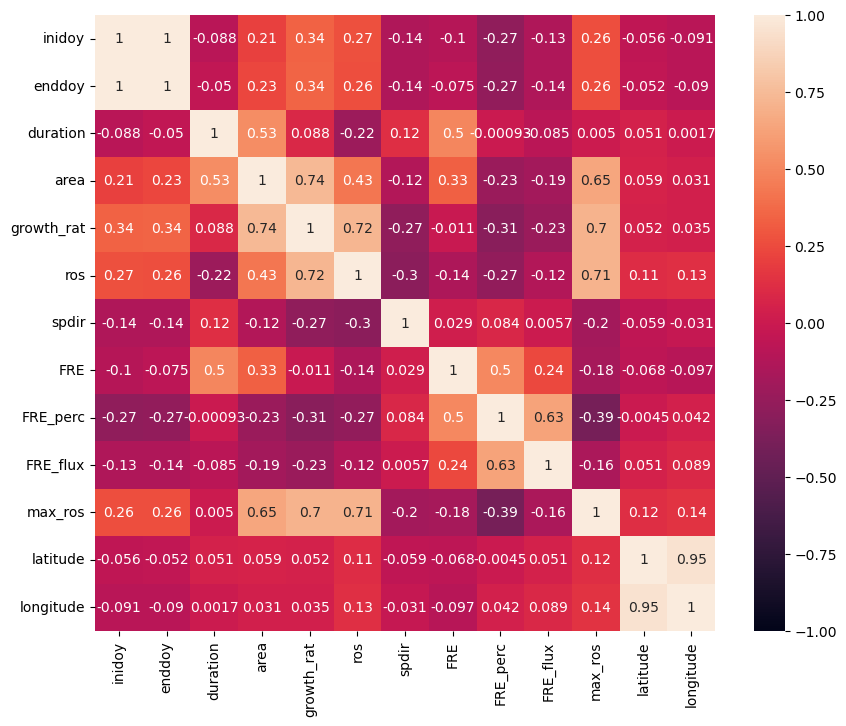

In [320]:
fig, ax = plt.subplots(figsize=(10, 8))
corr_heatmap=sns.heatmap(fs.corr(), vmin=-1, vmax=1, annot=True)

### Scatterplots

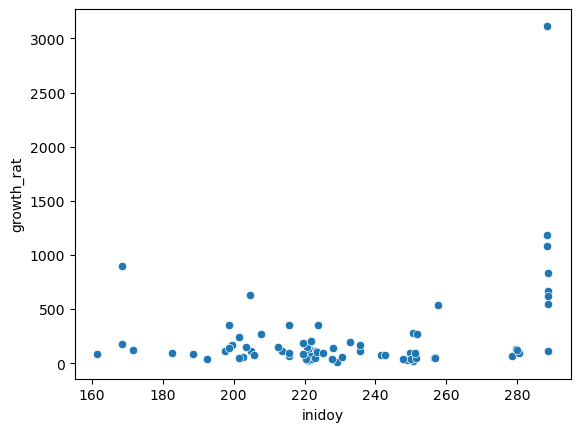

In [321]:
# There's a small positive correlation of doy and growth_rate

inidoy_gr=sns.scatterplot(data=fs, x="inidoy", y="growth_rat")

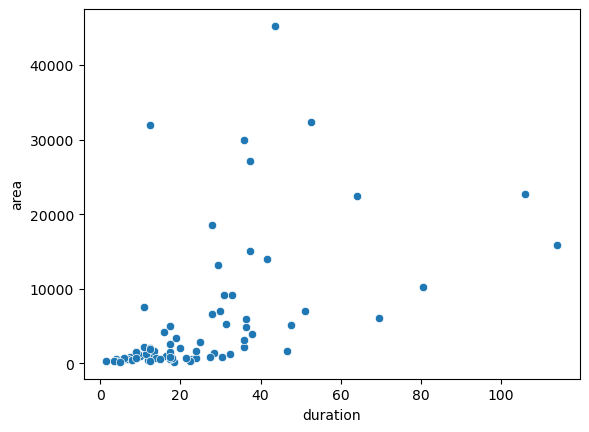

In [322]:
# At first there seems to be a high corr that drops probably due to weather conditions variation

area_dur=sns.scatterplot(data=fs, x="duration", y="area")

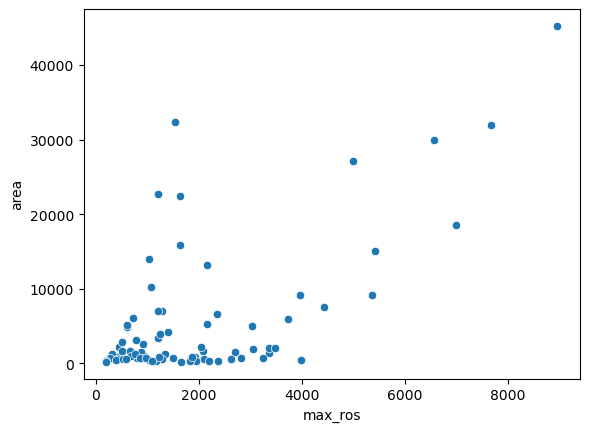

In [323]:
# Positive correlation between max rate of speed and burned area

area_maxros=sns.scatterplot(data=fs, x="max_ros", y="area")